In [4]:
import numpy as np
import pickle
import pandas as pd
import scipy as sp
import collections
import matplotlib.pyplot as plt
import json
import sys
import gzip
sys.path.append('/home/miaocj/docker_dir/kNN-overlap-finder/scripts')
from accelerate import open_gzipped,parse_fasta

In [ ]:
## 将降维后的gtdb feature matrxi 分成三份
gtdb = np.load('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/target_feature_matrix.npz')
gtdb_fm = gtdb['arr_0']
np.savez('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/part1/target_feature_matrix.npz', gtdb_fm[:10000000,:])
np.savez('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/part2/target_feature_matrix.npz', gtdb_fm[10000000:20000000,:])
np.savez('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/part3/target_feature_matrix.npz', gtdb_fm[20000000:,:])
qread_names = list(range(0,10000000))  
with open("/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/part1/target_name.txt", "wb") as file1:
    pickle.dump(qread_names, file1)  
qread_names = list(range(10000000,20000000))  
with open("/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/part2/target_name.txt", "wb") as file1:
    pickle.dump(qread_names, file1)  
qread_names = list(range(20000000,34435442))  
with open("/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/part3/target_name.txt", "wb") as file1:
    pickle.dump(qread_names, file1)  

In [9]:
def init_reverse_complement():
    TRANSLATION_TABLE = str.maketrans("ACTGactg", "TGACtgac")

    def reverse_complement(sequence: str) -> str:
        """
        >>> reverse_complement("AATC")
        'GATT'
        >>> reverse_complement("CCANT")
        'ANTGG'
        """
        sequence = str(sequence)
        return sequence.translate(TRANSLATION_TABLE)[::-1]

    return reverse_complement
reverse_complement = init_reverse_complement()
fasta_file = "/home/miaocj/docker_dir/kNN-overlap-finder/data/metagenome_reference/GTDB/mer_sampled.fa"
kmer_dict = collections.defaultdict()
all_kmer = []
for i,record in enumerate(parse_fasta(fasta_file)):
    all_kmer.append(record[1])
    all_kmer.append(reverse_complement(record[1]))
all_kmer_set = set(all_kmer)
for i,kmer in enumerate(all_kmer_set):
    kmer_dict[kmer] = i
print('kmer_dict building finished')

kmer_dict building finished


In [10]:
with open("/home/miaocj/docker_dir/kNN-overlap-finder/data/metagenome_reference/GTDB/kmer_dict.pkl", "wb") as file:
    pickle.dump(kmer_dict, file)

In [11]:
len(kmer_dict)

85432480

In [2]:
with open("/home/miaocj/docker_dir/kNN-overlap-finder/data/metagenome_reference/GTDB/kmer_dict.pkl", "rb") as file:
    kmer_dict = pickle.load(file)

In [3]:
len(kmer_dict)

85432480

In [12]:
max(list(kmer_dict.values()))

85432479

In [ ]:
df = pd.read_csv('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/metadata_all.tsv',sep='\t')

In [88]:
## 验证编码是否正确
fasta_file = "/home/miaocj/docker_dir/kNN-overlap-finder/data/metagenome_reference/GTDB/mer_sampled.fa"
kmer_dict = collections.defaultdict()
for i,record in enumerate(parse_fasta(fasta_file)):
    kmer_dict[record[1]] = i

In [ ]:
sequences = []
for record in parse_fasta('/home/miaocj/docker_dir/kNN-overlap-finder/data/metagenome_reference/GTDB/GTDB_1.fa'):
    sequences.append(record[1])

In [97]:
len(sequences[0])

19576

In [103]:
k=16
seq = sequences[1]
features_i = []
kmer_number = 0
for p in range(len(seq) - k + 1):
    kmer = seq[p : p + k]
    j = kmer_dict.get(kmer)
    kmer_number+=1
    if j is None:
        continue
    features_i.append(j)

In [104]:
len(features_i)

50

In [105]:
kmer_number

18080

In [100]:
len(features_i)

52

In [5]:
fm = sp.sparse.load_npz('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/feature_matrix_all.npz')

In [6]:
fm.max()

811

In [10]:
fm.dtype

dtype('int64')

In [8]:
matrix_uint16 = fm.astype(np.uint16)

In [12]:
matrix_uint16.dtype

dtype('uint16')

In [14]:
output_ref_npz_file = f'/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/feature_matrix_all_unit16.npz'
sp.sparse.save_npz(output_ref_npz_file, matrix_uint16)

In [2]:
fm = sp.sparse.load_npz('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/chr1_248M/real_cyclone/kmer_k16/feature_matrix.npz')

In [3]:
fm.shape

(716826, 92347739)

In [110]:
fm[1,:].nnz

341

In [108]:
len(kmer_dict)

10735133

In [13]:
fm1 = sp.sparse.load_npz('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/feature_matrix_1.npz')
fm2 = sp.sparse.load_npz('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/feature_matrix_2.npz')

In [14]:
fm1.shape

(400000, 85432480)

In [5]:
fm2.shape

(400000, 10735133)

验证chr1的nnz情况和长度的关系

In [20]:
rf_len = []
with gzip.open('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/chr1_248M/real_cyclone/kmer_k16/read_features.json.gz') as f:
    rf = json.load(f)
for li in rf:
    rf_len.append(len(li))
rflen_counter = collections.Counter(rf_len)

(0.0, 1400.0)

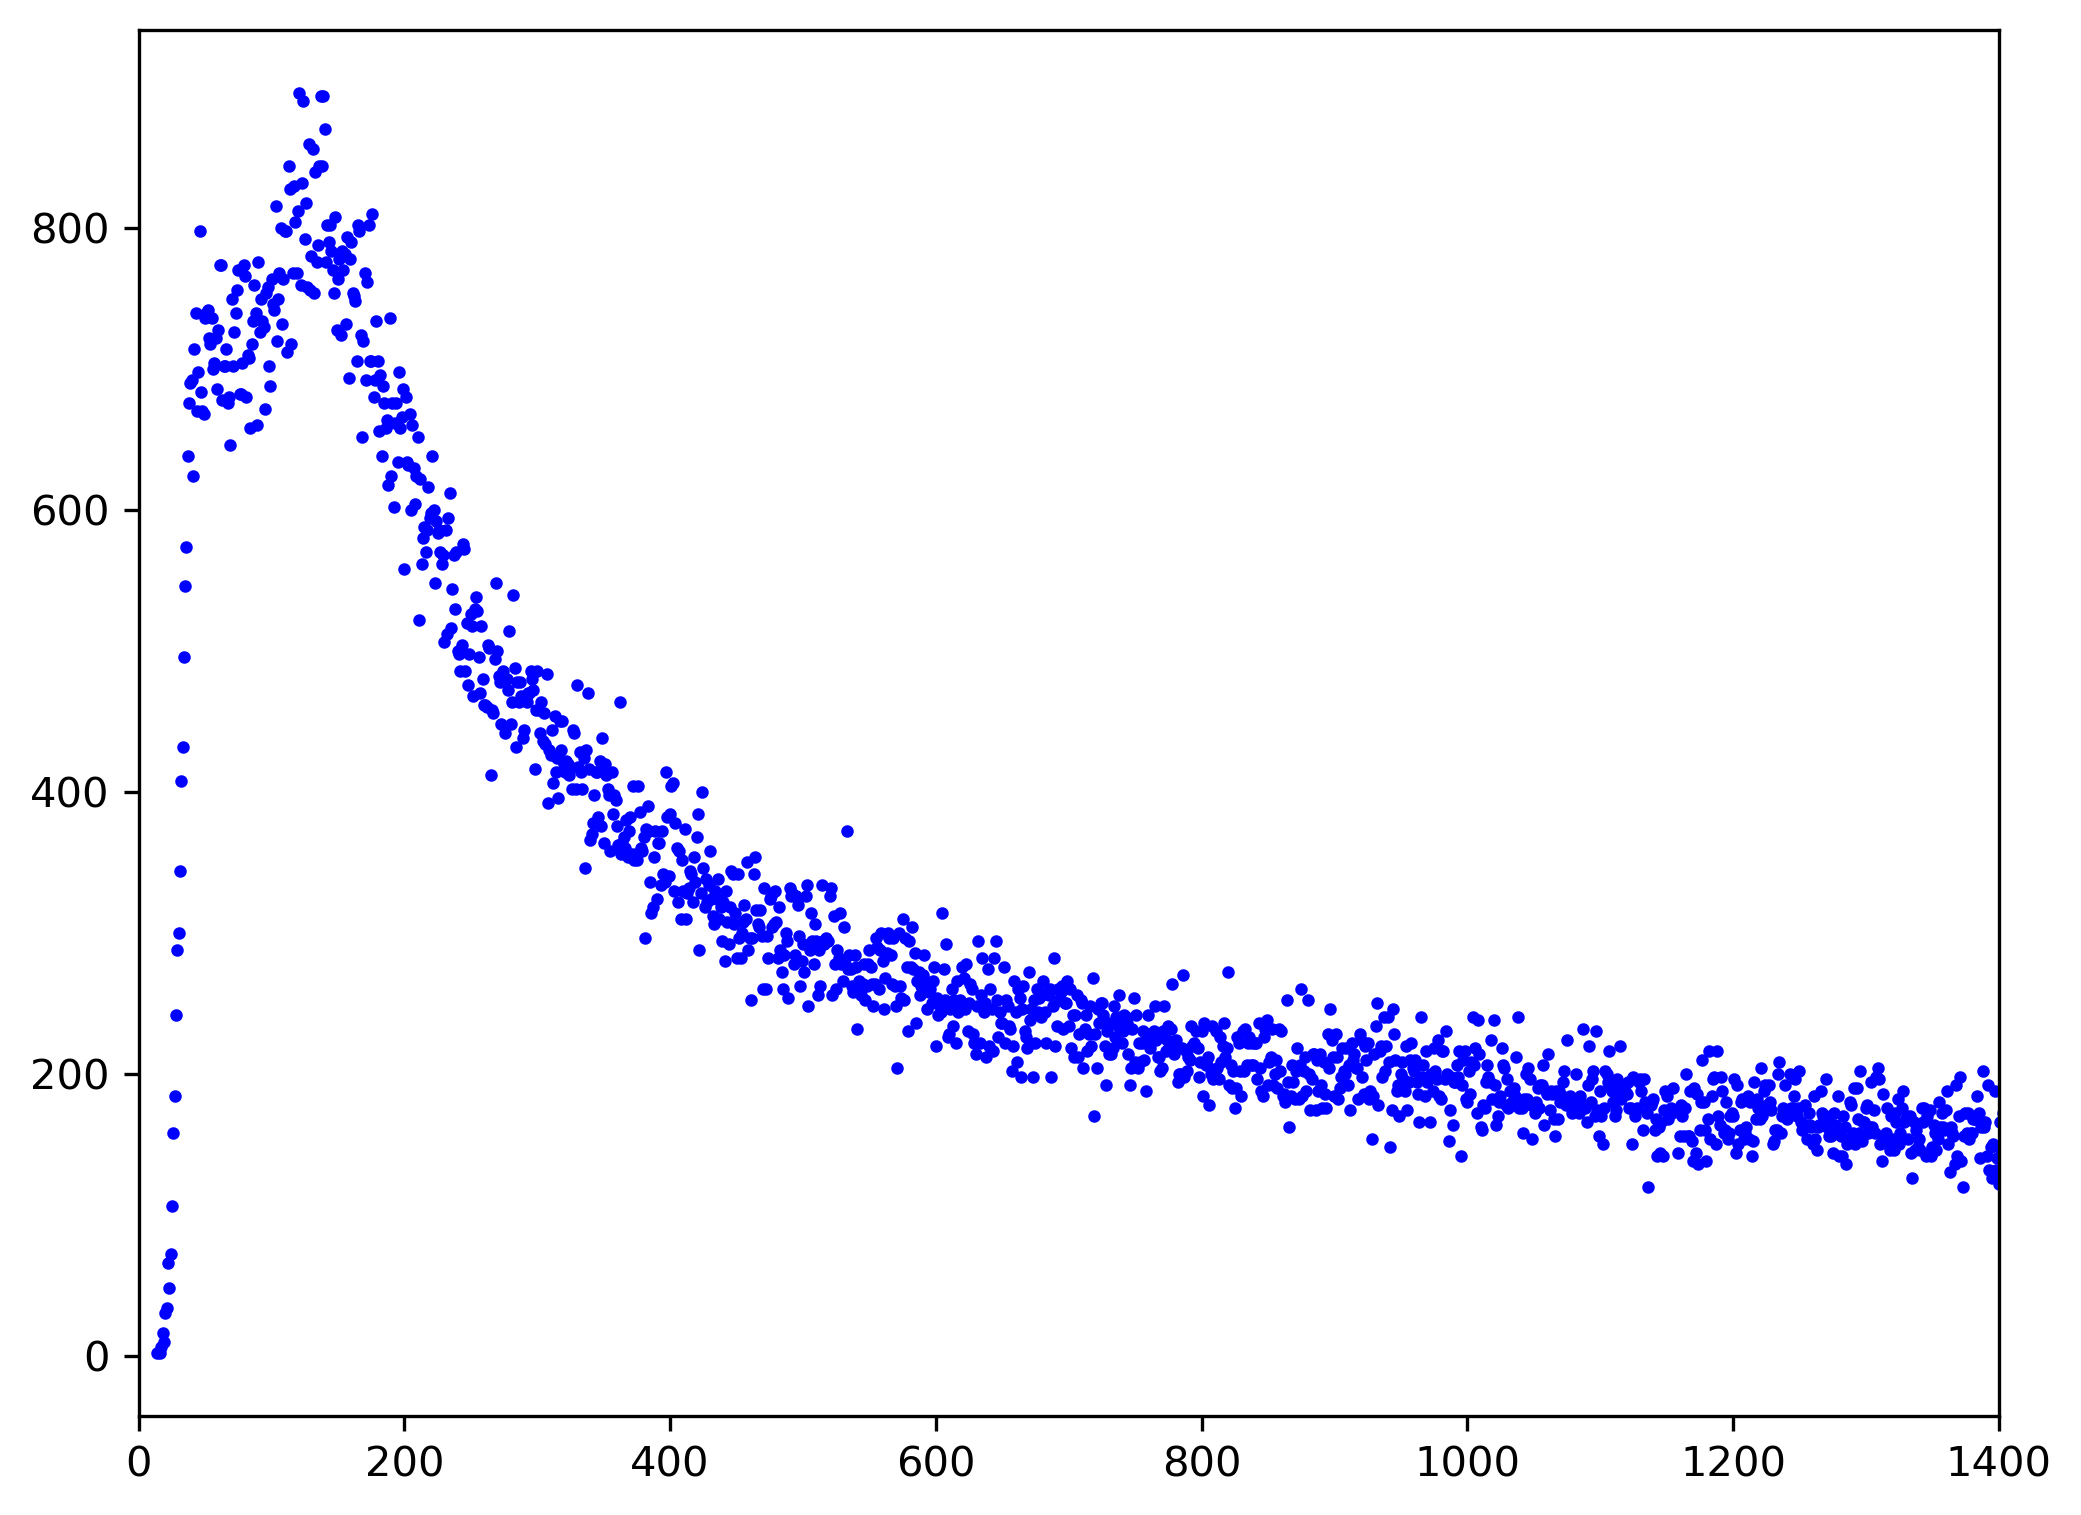

In [28]:
plt.rcParams['figure.dpi'] = 300 
x = list(rflen_counter.keys())  # 键作为 x 轴
y = list(rflen_counter.values())  # 值作为 y 轴
plt.figure(figsize=(8, 6))  # 设置图形大小
plt.scatter(x, y, marker='o', color='b',s =4)
plt.xlim(0,1400)

In [ ]:
seqlen = []
for seq in parse_fasta('/home/miaocj/docker_dir/kNN-overlap-finder/data/regional_reads/CHM13/chr1_248M/real_cyclone/reads.fasta.gz'):
    seqlen.append(len(seq[1]))
seqlen_counter = collections.Counter(seqlen)
plt.rcParams['figure.dpi'] = 300 
x = list(seqlen_counter.keys())  # 键作为 x 轴
y = list(seqlen_counter.values())  # 值作为 y 轴
plt.figure(figsize=(8, 6))  # 设置图形大小
plt.scatter(x, y, marker='o', color='b',s =4)  
plt.xlim(0,20000)

(0.0, 20000.0)

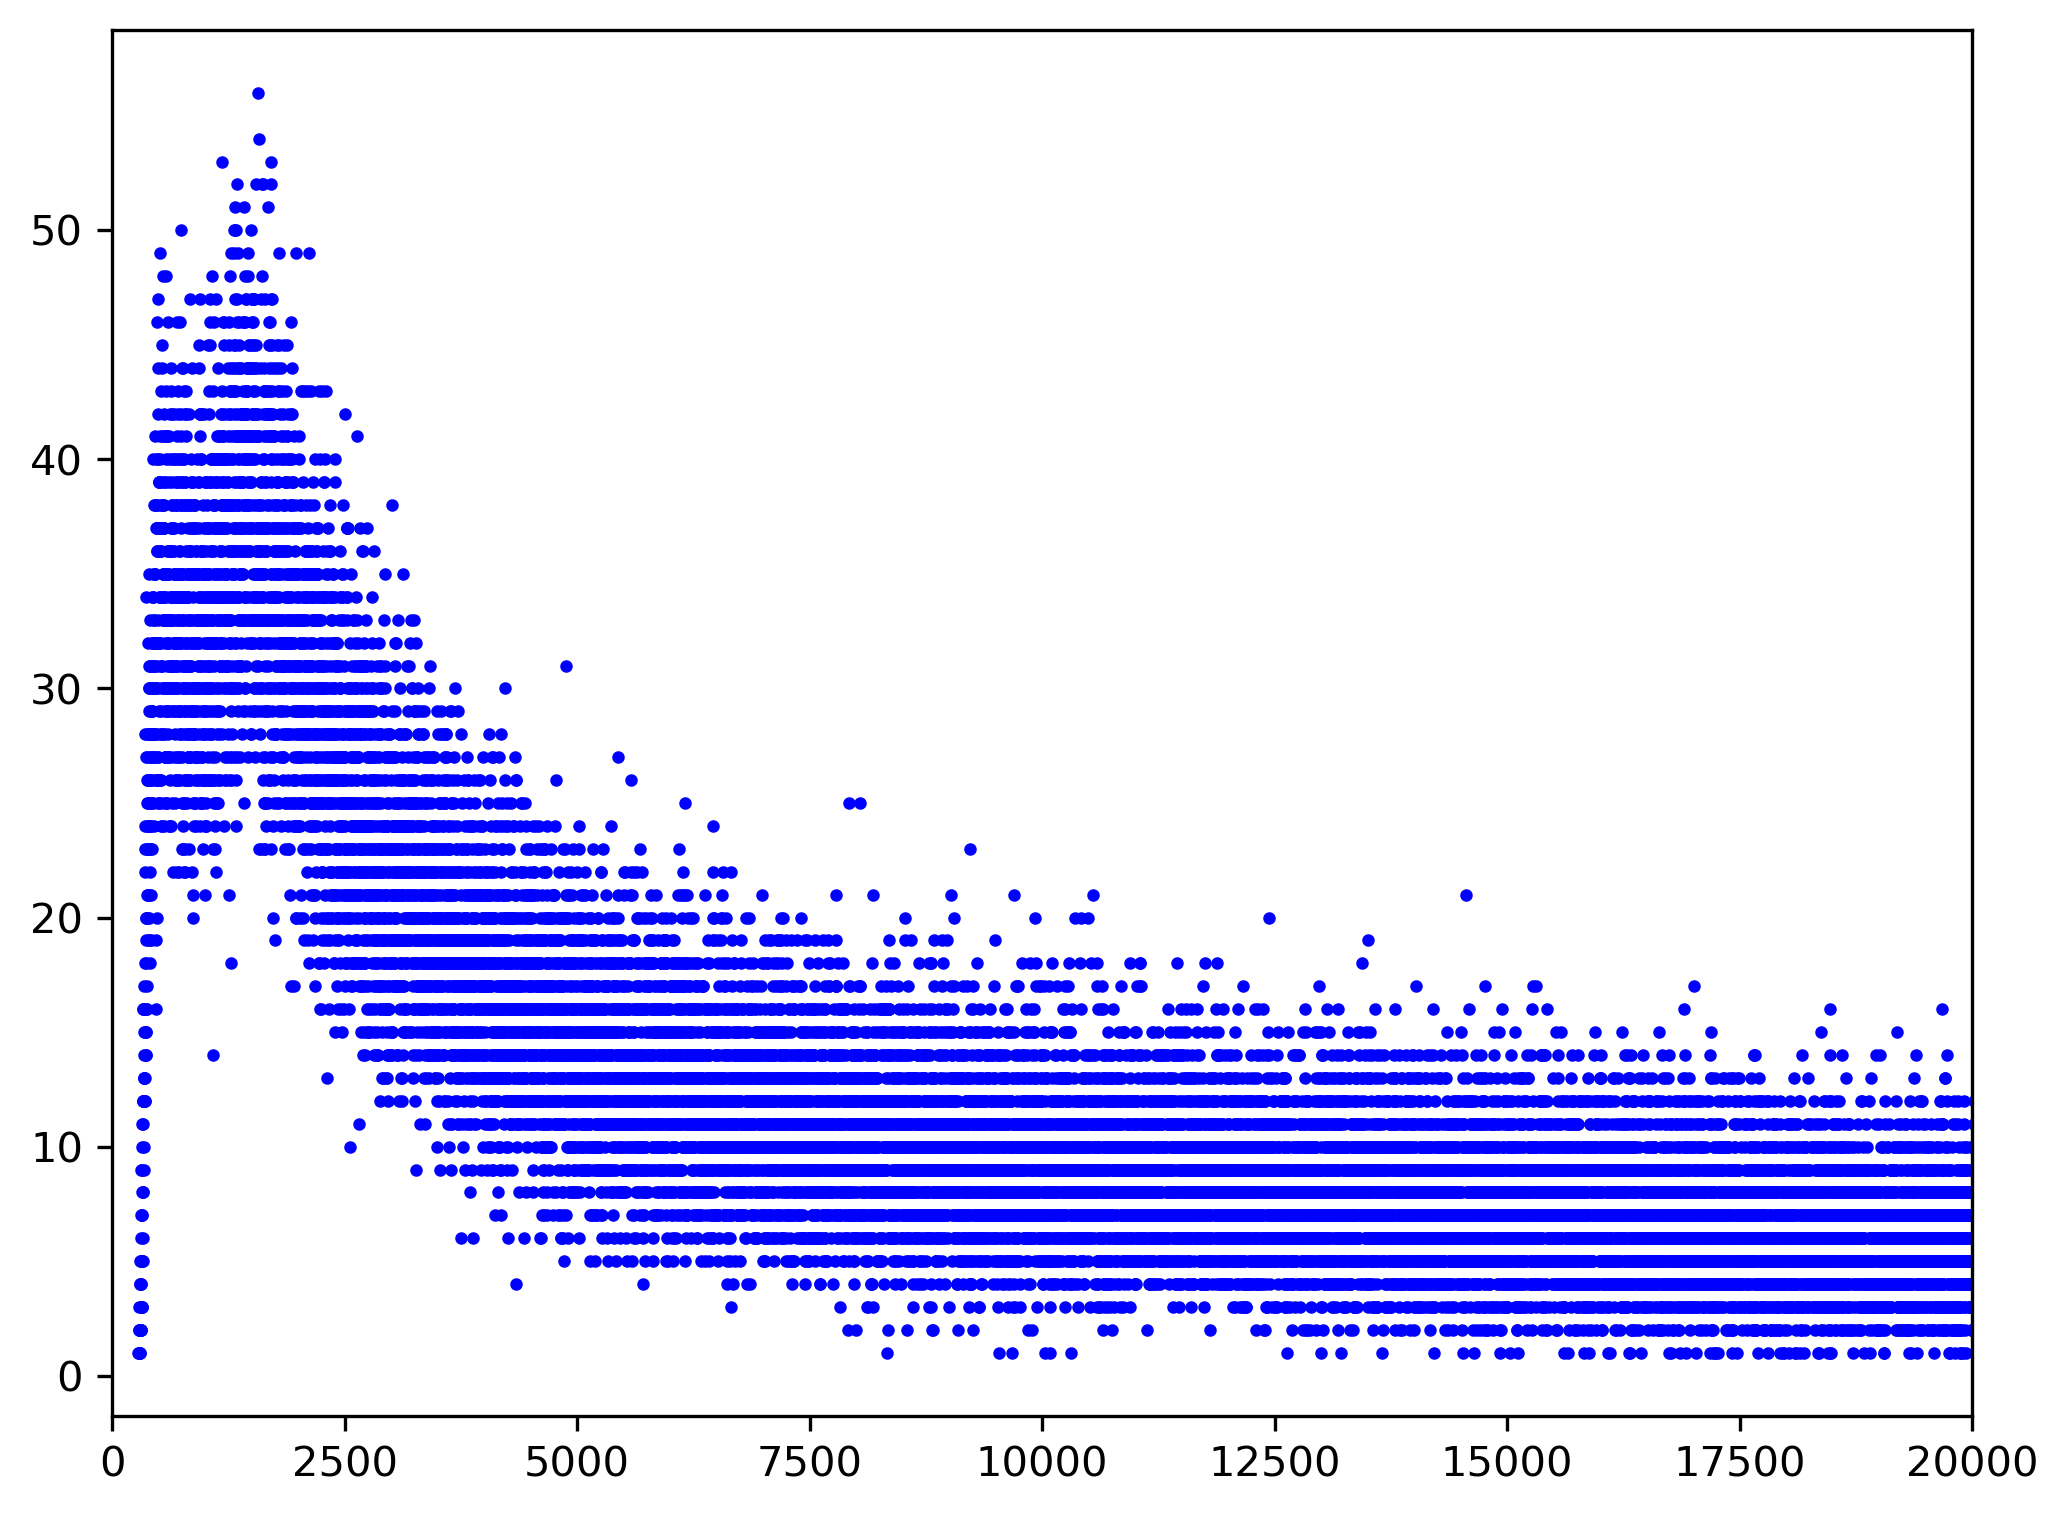

验证featurematrix 的非零值

In [ ]:
fm = sp.sparse.load_npz('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/feature_matrix_all.npz')
all_nnz = []
for i in range(0,34435442):
    nnz = fm[i,:].nnz
    all_nnz.append(nnz) 

In [23]:
with gzip.open("/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/read_features_1.npz",'r') as f:
    read_features = json.load(f)
feature_len = []
for i in read_features[:50000]:
    feature_len.append(len(i))
di = collections.Counter(feature_len)

(0.0, 20000.0)

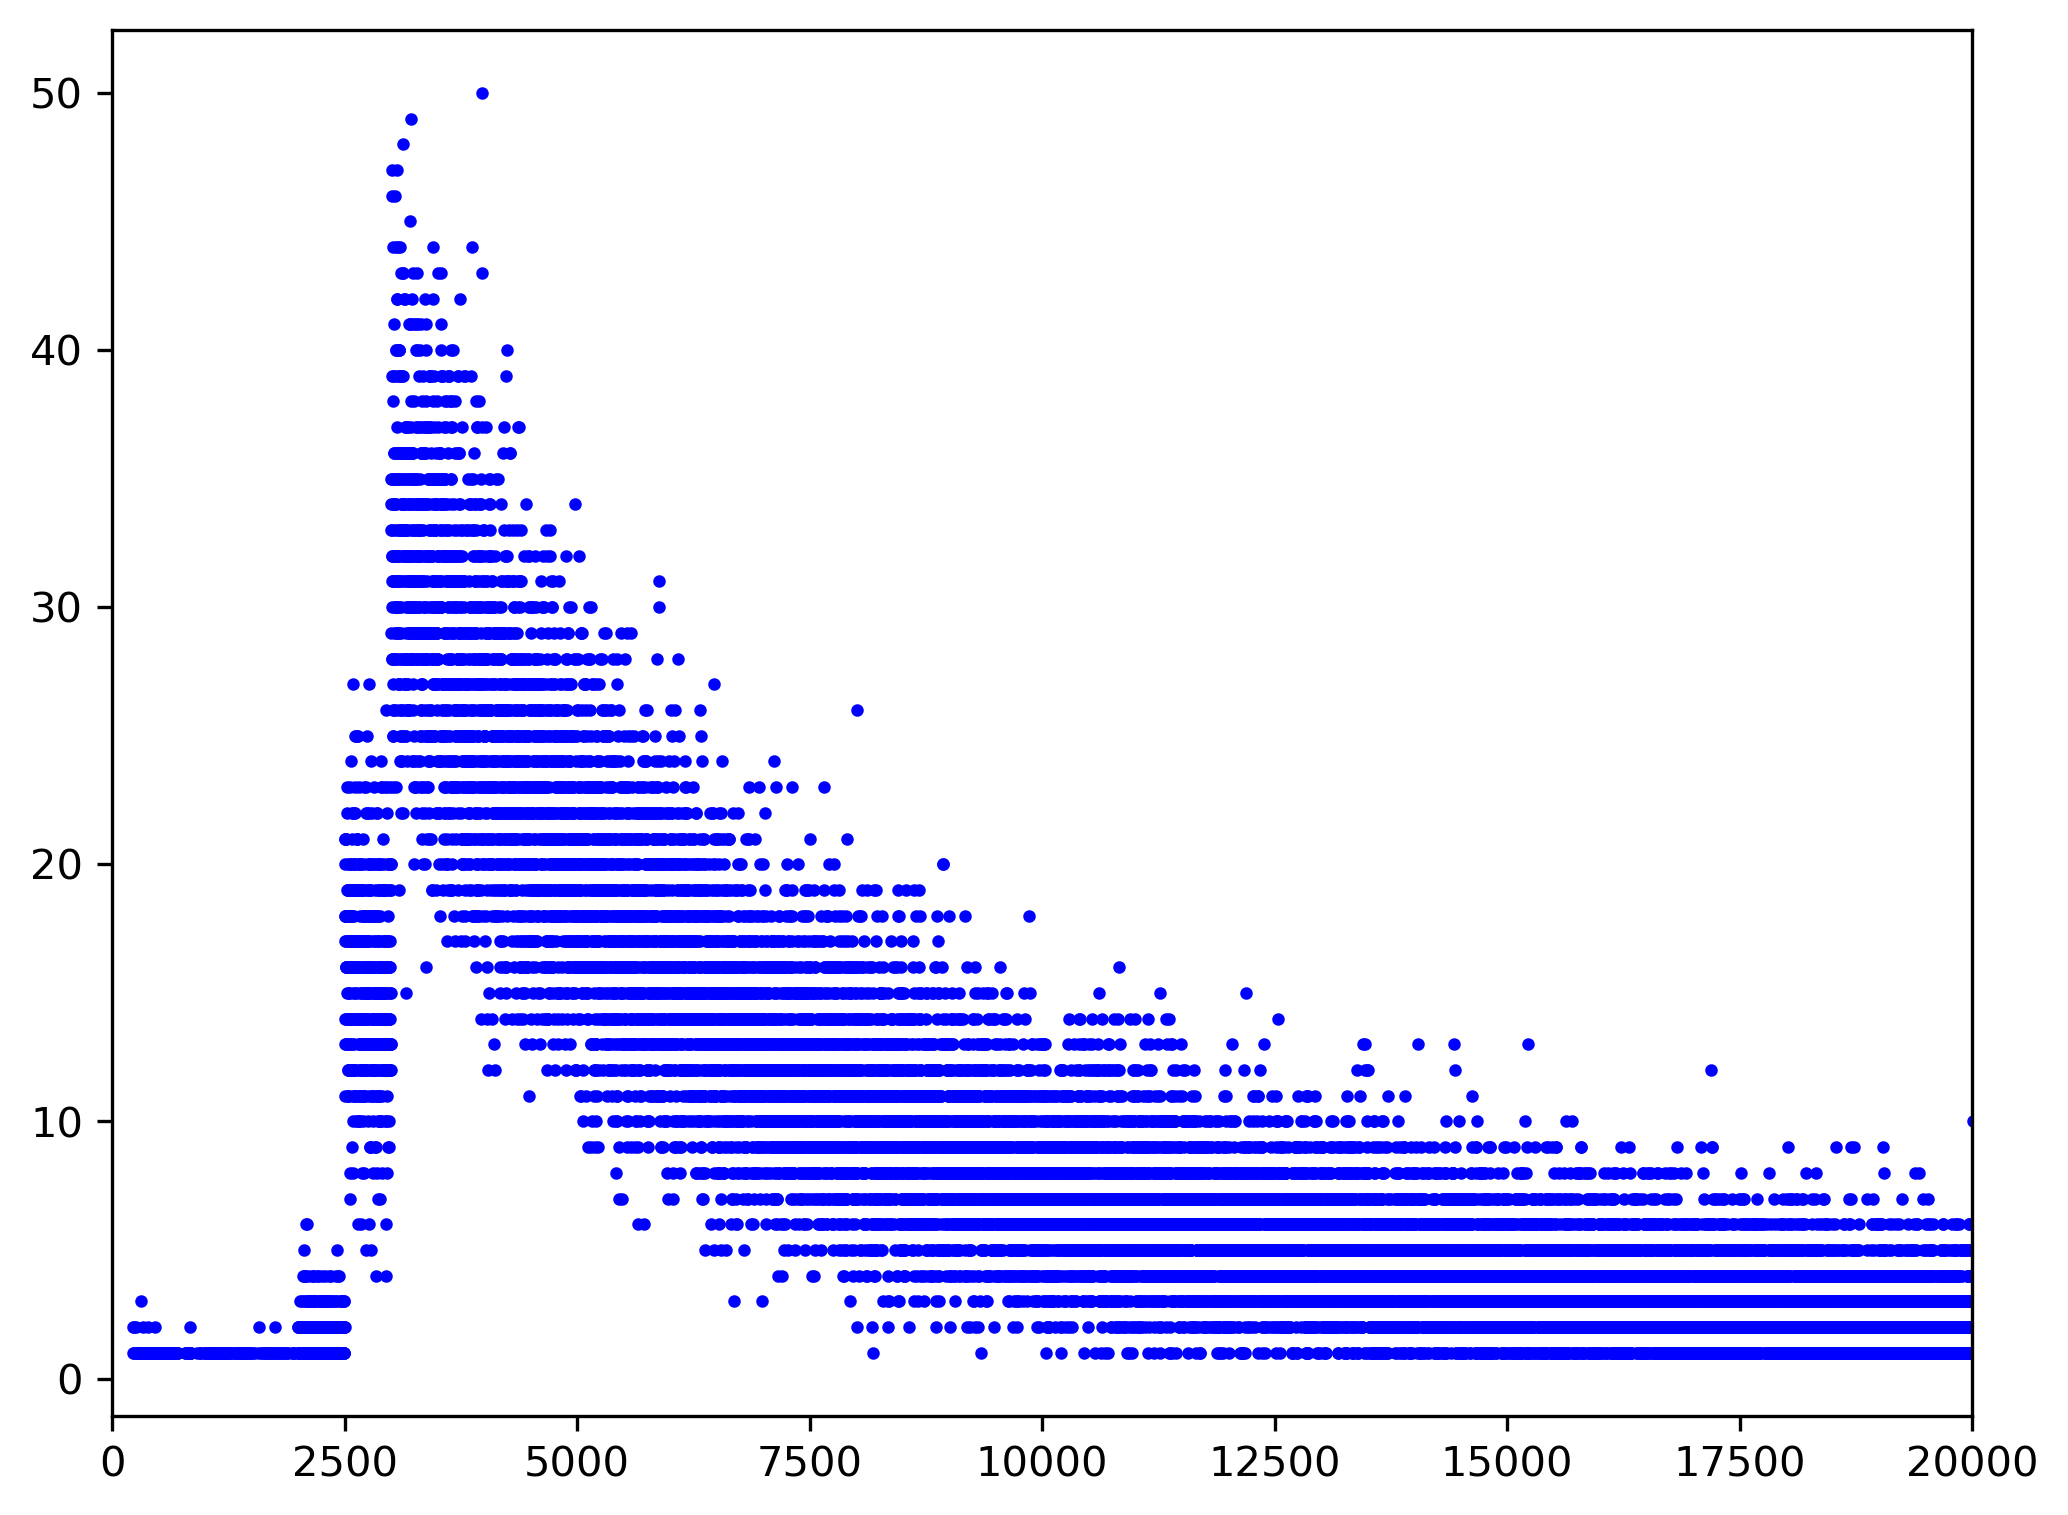

In [31]:
seqlen = []
for seq in parse_fasta('/home/miaocj/docker_dir/kNN-overlap-finder/data/metagenome_reference/GTDB/GTDB_1.fa'):
    seqlen.append(len(seq[1]))
seqlen_counter = collections.Counter(seqlen)
plt.rcParams['figure.dpi'] = 300 
x = list(seqlen_counter.keys())  # 键作为 x 轴
y = list(seqlen_counter.values())  # 值作为 y 轴
plt.figure(figsize=(8, 6))  # 设置图形大小
plt.scatter(x, y, marker='o', color='b',s =4)  
plt.xlim(0,20000)

(0.0, 1400.0)

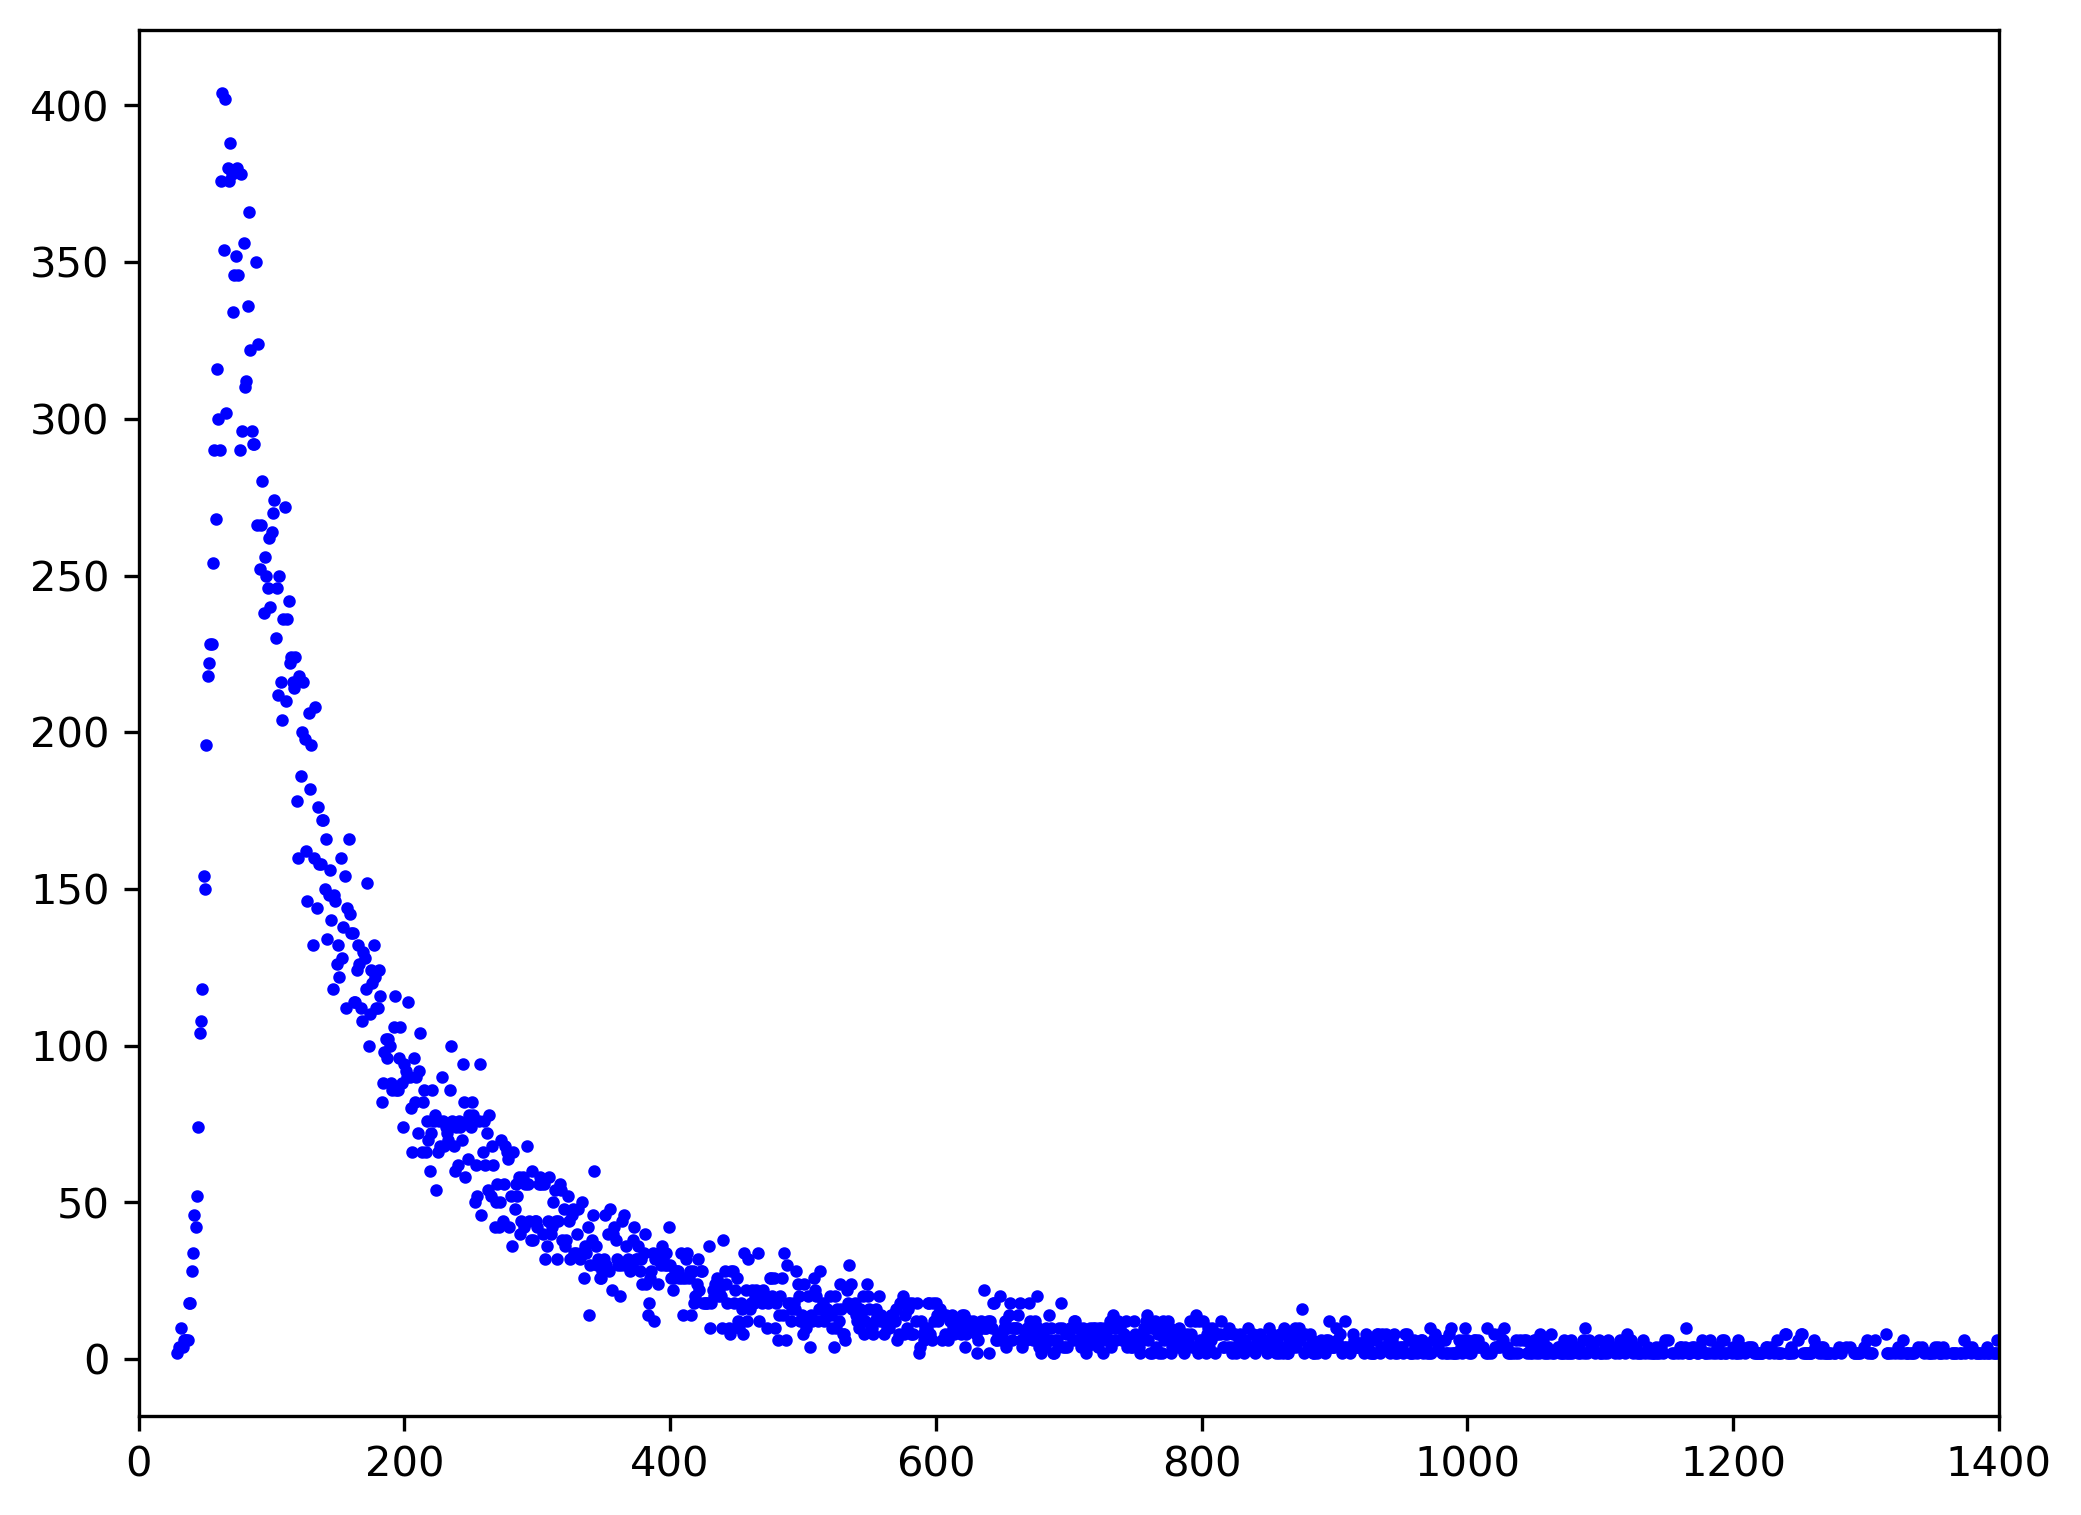

In [27]:
plt.rcParams['figure.dpi'] = 300 
x = list(di.keys())  # 键作为 x 轴
y = list(di.values())  # 值作为 y 轴
plt.figure(figsize=(8, 6))  # 设置图形大小
plt.scatter(x, y, marker='o', color='b',s =4)  
plt.xlim(0,1400)

(0.0, 20000.0)

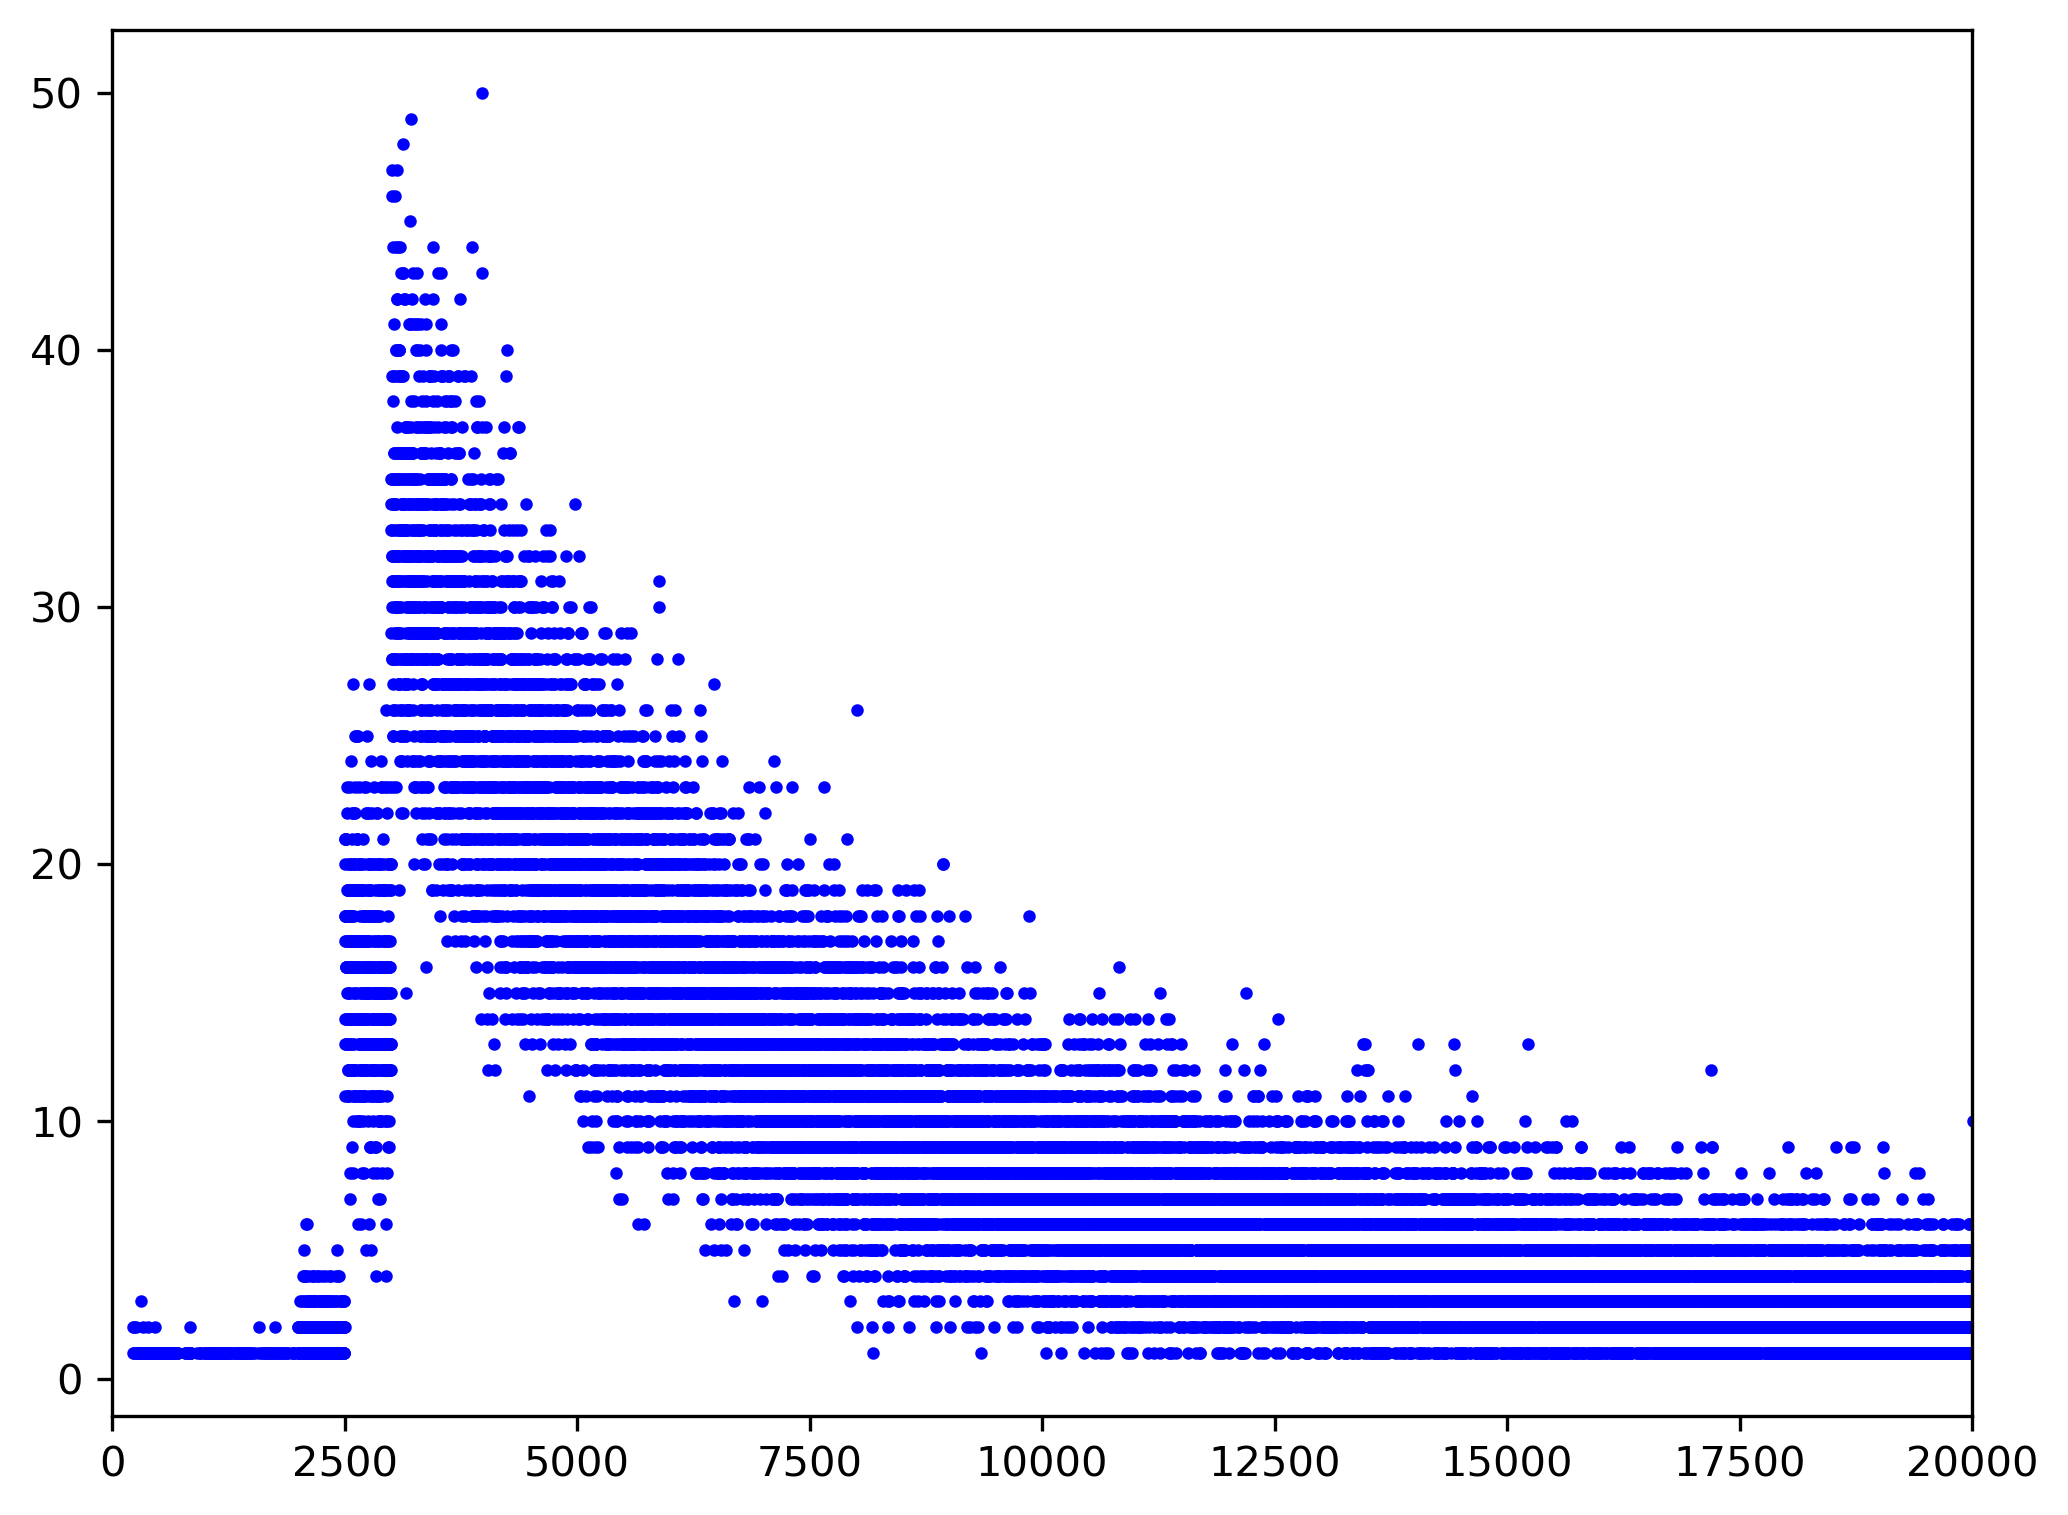

In [84]:
seqlen_counter = collections.Counter(seqlen)
plt.rcParams['figure.dpi'] = 300 
x = list(seqlen_counter.keys())  # 键作为 x 轴
y = list(seqlen_counter.values())  # 值作为 y 轴
plt.figure(figsize=(8, 6))  # 设置图形大小
plt.scatter(x, y, marker='o', color='b',s =4)  
plt.xlim(0,20000)

In [64]:
fm = sp.sparse.load_npz('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/feature_matrix_1.npz')

In [65]:
fm.shape

(400000, 10735133)

In [66]:
all_nnz = []
for i in range(0,400000):
    nnz = fm[i,:].nnz
    all_nnz.append(nnz)

In [67]:
nnz_counter = collections.Counter(all_nnz)

In [71]:
max(sorted(di))

10626

In [68]:
max(sorted(nnz_counter))

10309

In [41]:
nnz_counter[37013]

1

(0.0, 200.0)

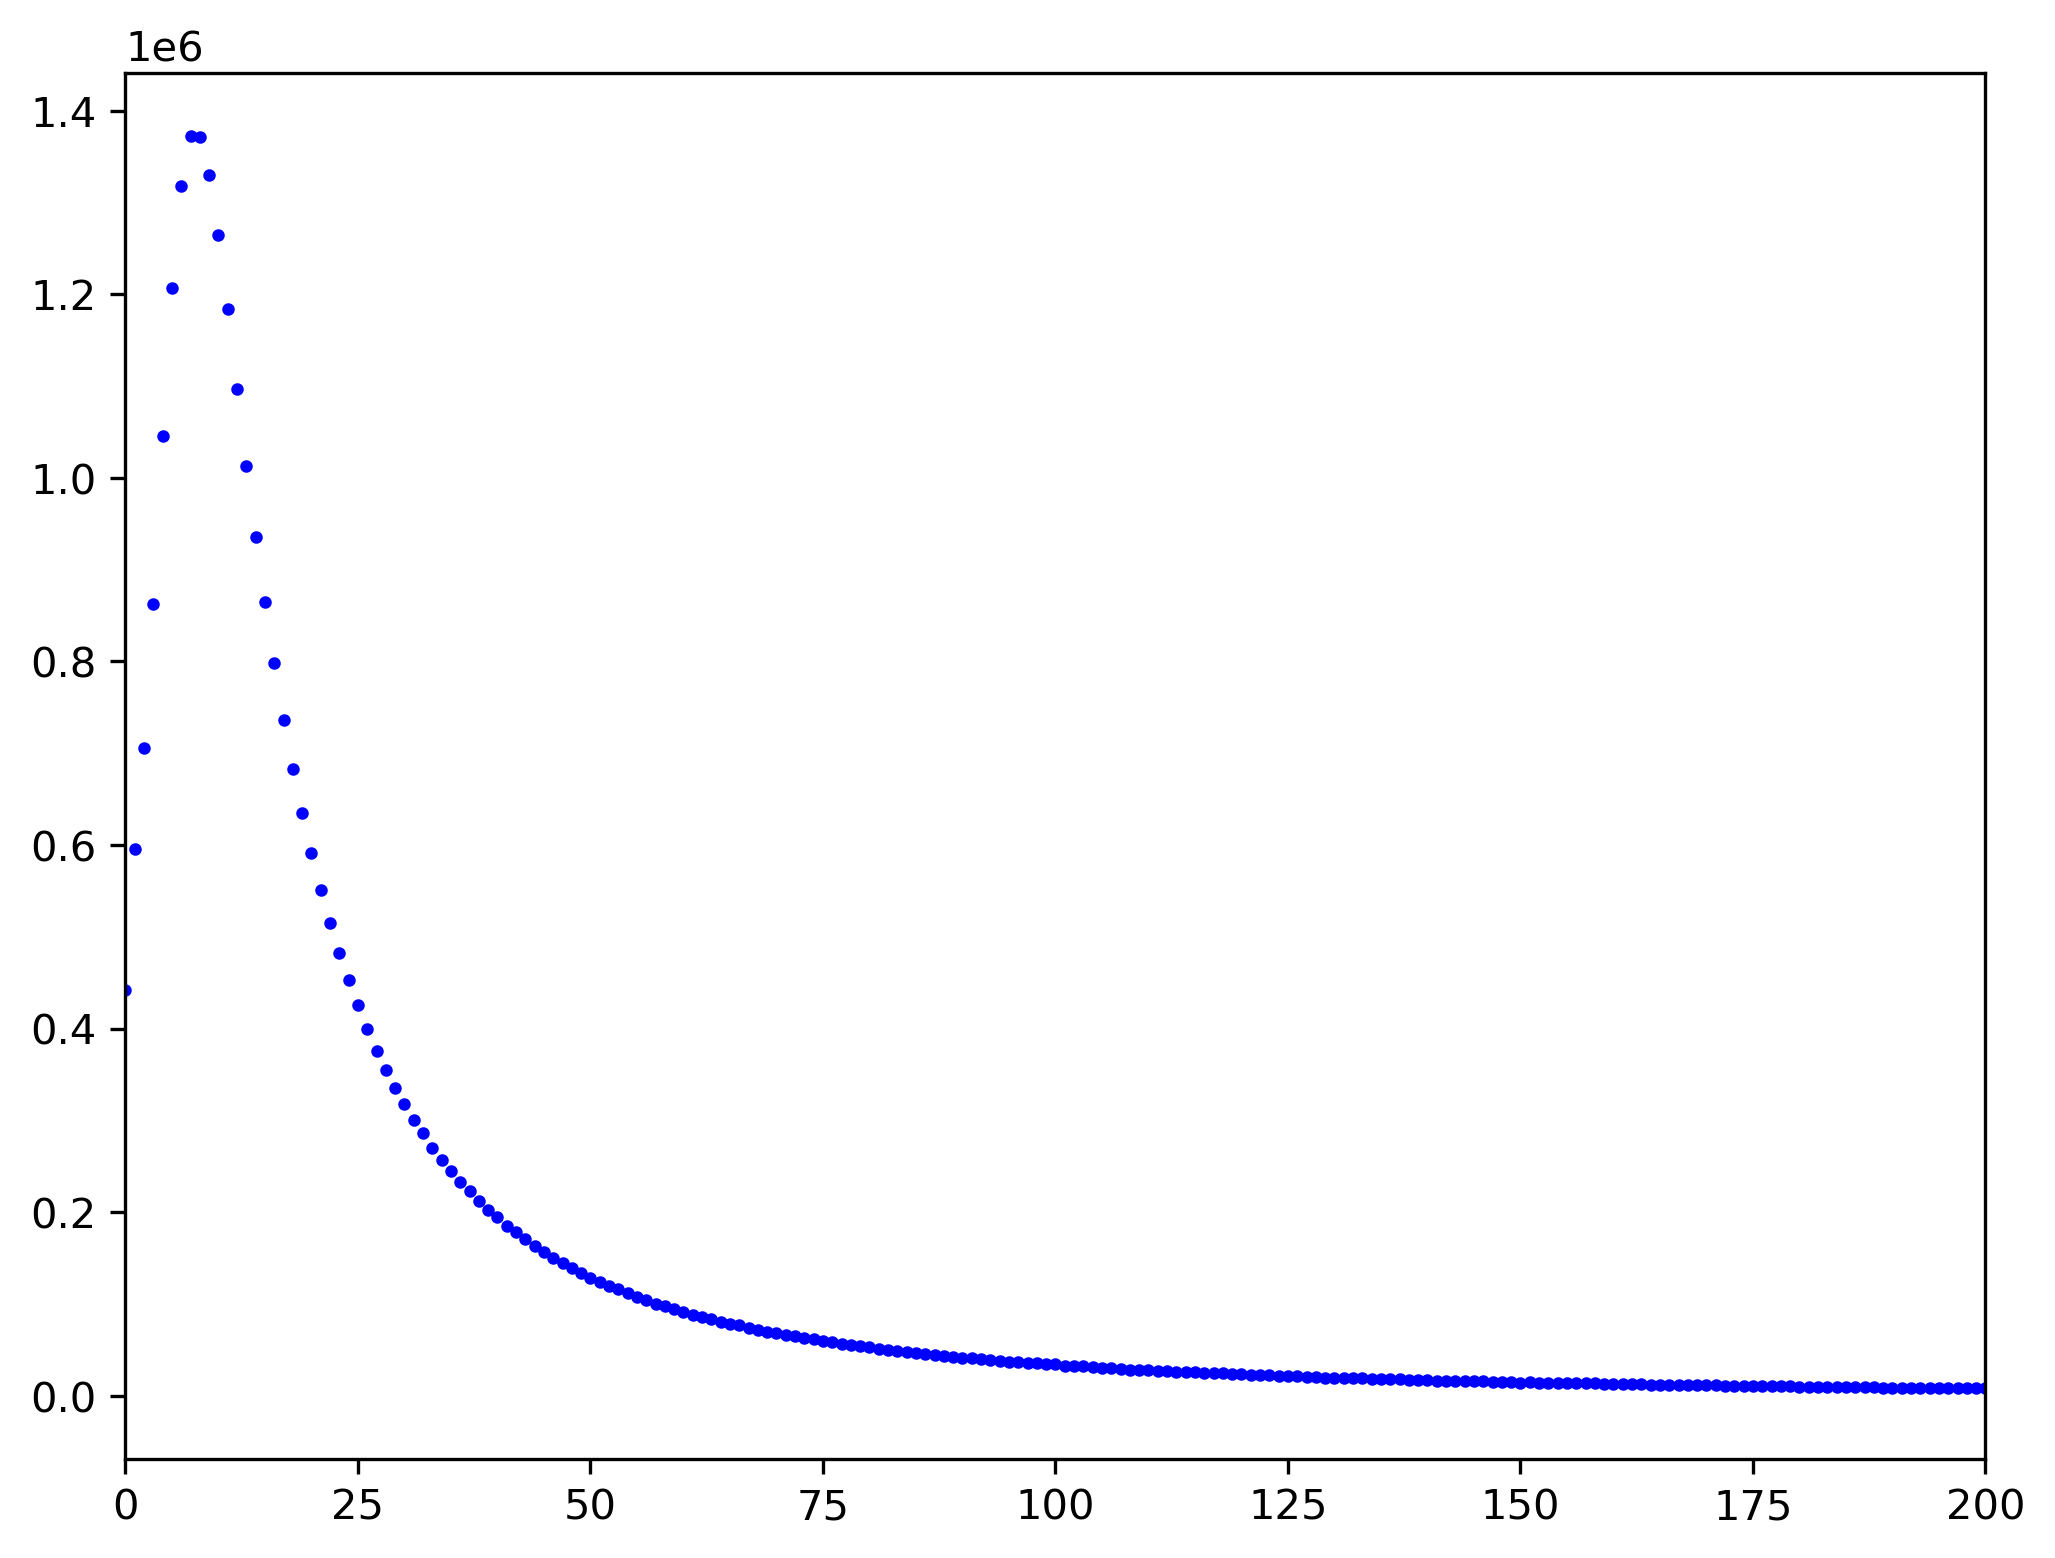

In [53]:
plt.rcParams['figure.dpi'] = 300 
x = list(nnz_counter.keys())  # 键作为 x 轴
y = list(nnz_counter.values())  # 值作为 y 轴
plt.figure(figsize=(8, 6))  # 设置图形大小
plt.scatter(x, y, marker='o', color='b',s =4)  
plt.xlim(0,200)

In [35]:
sort_nnz_counter = {key: nnz_counter[key] for key in sorted(nnz_counter)}

In [ ]:
all_index_nnz = []
with open('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/uniq_index') as f:
    for lines in f.readlines():
        index = int(lines.strip())
        print(index)
        nnz = fm[index,:].nnz
        all_index_nnz.append(nnz)

In [27]:
sum(all_index_nnz)

9

In [6]:
df2= pd.read_csv('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/metadata_86.tsv.gz',sep='\t')

In [7]:
df2

,read_id,read_name,read_orientation,gca_id,species
0,34000000,NZ_BAEG01000044.1,+,RS_GCF_000238915.1,Arthrobacter globiformis
1,34000001,NZ_BAEG01000044.1,-,RS_GCF_000238915.1,Arthrobacter globiformis
2,34000002,NZ_BAEG01000043.1,+,RS_GCF_000238915.1,Arthrobacter globiformis
3,34000003,NZ_BAEG01000043.1,-,RS_GCF_000238915.1,Arthrobacter globiformis
4,34000004,NZ_BAEG01000042.1,+,RS_GCF_000238915.1,Arthrobacter globiformis
...,...,...,...,...,...
399995,34399995,NZ_JADBTX010000073.1,-,RS_GCF_020245945.1,Microcystis sp020245945
399996,34399996,NZ_JADBTX010000074.1,+,RS_GCF_020245945.1,Microcystis sp020245945
399997,34399997,NZ_JADBTX010000074.1,-,RS_GCF_020245945.1,Microcystis sp020245945
399998,34399998,NZ_JADBTX010000075.1,+,RS_GCF_020245945.1,Microcystis sp020245945


In [5]:
df2

,read_id,read_name,read_orientation,gca_id,species
0,17200000,NZ_JADBTX010000076.1,+,RS_GCF_020245945.1,Microcystis sp020245945
1,17200001,NZ_JADBTX010000076.1,-,RS_GCF_020245945.1,Microcystis sp020245945
2,17200002,NZ_JADBTX010000077.1,+,RS_GCF_020245945.1,Microcystis sp020245945
3,17200003,NZ_JADBTX010000077.1,-,RS_GCF_020245945.1,Microcystis sp020245945
4,17200004,NZ_JADBTX010000078.1,+,RS_GCF_020245945.1,Microcystis sp020245945
...,...,...,...,...,...
35437,17235437,NZ_JAVIFU010000161.1,-,RS_GCF_031157315.1,Pristimantibacillus sp031157315
35438,17235438,NZ_JAVIFU010000162.1,+,RS_GCF_031157315.1,Pristimantibacillus sp031157315
35439,17235439,NZ_JAVIFU010000162.1,-,RS_GCF_031157315.1,Pristimantibacillus sp031157315
35440,17235440,NZ_JAVIFU010000163.1,+,RS_GCF_031157315.1,Pristimantibacillus sp031157315


In [9]:
df

,read_id,read_name,read_orientation,gca_id,species
0,0,CALZMS010000001.1,+,GB_GCA_945788595.1,UBA11957 sp945788595
1,1,CALZMS010000001.1,-,GB_GCA_945788595.1,UBA11957 sp945788595
2,2,CALZMS010000002.1,+,GB_GCA_945788595.1,UBA11957 sp945788595
3,3,CALZMS010000002.1,-,GB_GCA_945788595.1,UBA11957 sp945788595
4,4,CALZMS010000003.1,+,GB_GCA_945788595.1,UBA11957 sp945788595
...,...,...,...,...,...
34435437,34435437,NZ_JAVIFU010000161.1,-,RS_GCF_031157315.1,Pristimantibacillus sp031157315
34435438,34435438,NZ_JAVIFU010000162.1,+,RS_GCF_031157315.1,Pristimantibacillus sp031157315
34435439,34435439,NZ_JAVIFU010000162.1,-,RS_GCF_031157315.1,Pristimantibacillus sp031157315
34435440,34435440,NZ_JAVIFU010000163.1,+,RS_GCF_031157315.1,Pristimantibacillus sp031157315


In [37]:
len(set(df['read_id'].tolist()))

34400000

In [10]:
df.at[10170139,'read_name']

'CAJTCU010000104.1'

In [ ]:
names = []
#file = open('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/uniq_names','wt')
with open('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/uniq_index') as f:
    for lines in f.readlines():
        index = lines.strip()
        read_name = df.at[int(index),'read_name']
        species = df.at[int(index),'species']
        names.append(read_name)
        #file.write(read_name+'\n')
        

In [33]:
indexs = []
with open('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/uniq_index') as f:
    for lines in f.readlines():
        index = int(lines.strip())
        indexs.append(index)

In [35]:
max(indexs)

34023269

In [16]:
import pandas as pd

# 假设 df 是已经加载的 DataFrame
# df = pd.read_csv('your_dataframe_file.csv')

# 打开输出文件
output_file_path = '/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/uniq_names'
# 打开输出文件
output_file_path2 = '/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/species'
input_file_path = '/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/uniq_index'

# 使用 with 语句确保文件正确关闭
with open(output_file_path, 'w') as file,  open(output_file_path2, 'w') as file2, open(input_file_path, 'r') as f:
    for line in f:  # 逐行迭代，避免内存占用过高
        index = line.strip()
        index = int(index)
        # 获取 DataFrame 中的值
        read_name = df.at[index, 'read_name']
        species = df.at[index, 'species']
        # 写入文件
        file.write(read_name + '\n')
        file2.write(species + '\n')

In [21]:
real_sp = '/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/uniq_real_tax'
pred_sp = '/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1/uniq_species'
with open(real_sp,'r') as real, open(pred_sp,'r') as pred:
    for sp1 in real:
        for sp2 in pred:
            if sp1 in sp2:
                print(sp1,sp2)

In [22]:
import scipy as sp
df = sp.sparse.load_npz('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/sample1.npz')

In [25]:
df.shape

(1666307, 10735133)

In [ ]:
df.nnz ##平均每行 7.47个

12457686

In [27]:
import scipy as sp
fm2 = sp.sparse.load_npz('/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/metagenome/GTDB/feature_matrix_10.npz')

In [28]:
fm2.nnz

12900021

In [ ]:
fm2.shape ## 平均每行32个

(400000, 10735133)